# **ETL -IMAGES**

In [30]:
# [Config] Librerías
import pandas as pd
import os, re 
import nibabel as nib
from datetime import datetime
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib as plt
import statsmodels
from statsmodels.stats.proportion import proportions_ztest
import os
import numpy as np
import SimpleITK as sitk
from pathlib import Path

## _Imágenes descargadas_

> Leer atributos de las imágenes

In [3]:
# CARACTERISTICAS DE LAS IMAGENES DESCARGADAS

# [Config] Rutas
output_dir  = r"C:\Users\usuario\MRI\IMAGES_NII"

# [] Guardar atributos de las imágenes
records = []

for root, dirs, files in os.walk(output_dir):
    for file in files:
        if file.endswith(".nii"):
            full_path = os.path.normpath(os.path.join(root, file))

            # 🧩 Extraer ID del sujeto
            match_id = re.search(r'(\d{3}_S_\d{4})', full_path)
            sujeto_id = match_id.group(1) if match_id else None

            # 🗓️ Extraer fecha del estudio (YYYY-MM-DD)
            match_fecha = re.search(r'(\d{4}-\d{2}-\d{2})', full_path)
            fecha = match_fecha.group(1) if match_fecha else None

            # 🔑 Extraer ID de imagen (ej. I######)
            match_img = re.search(r'(I\d+)', full_path)
            imagen_id = match_img.group(1) if match_img else None

            # Leer metadatos del NIfTI
            try:
                img = nib.load(full_path)
                data = img.get_fdata()

                header = img.header
                shape = img.shape
                voxel_size = header.get_zooms()
                voxel_volume = np.prod(voxel_size)
                total_volume = voxel_volume*np.prod(shape)
                datatype = str(header.get_data_dtype())
                mean_intensity = np.mean(data)
                std_intensity = np.std(data)
                orientation = nib.aff2axcodes(img.affine)
                units = header.get_xyzt_units()

                records.append([
                    sujeto_id, fecha, imagen_id, 
                    shape, voxel_size, datatype,
                    voxel_volume, total_volume, 
                    mean_intensity, std_intensity,
                    orientation, units, full_path
                ])
            except Exception as e:
                print(f"⚠️ Error leyendo {file}: {e}")

df_images = pd.DataFrame(records, columns=[
    "sujeto_id", "fecha_imagen", "imagen_id",
    "shape", "voxel_size", "datatype",
    "voxel_volume_mm3", "total_volume", 
    "mean_intensity", "std_intensity", 
    "orientation", "units","ruta"
])

# Convertir fecha a tipo datetime
df_images["fecha_imagen"] = pd.to_datetime(df_images["fecha_imagen"], errors="coerce")

print(f"En total {len(df_images)} imágenes fueron cargadas correctamente.")

En total 220 imágenes fueron cargadas correctamente.


In [4]:
df_images.to_csv('./Data/ADNI_Images.csv', index=False)
df_images.head()

,sujeto_id,fecha_imagen,imagen_id,shape,voxel_size,datatype,voxel_volume_mm3,total_volume,mean_intensity,std_intensity,orientation,units,ruta
0,007_S_0101,2007-07-11,I62166,"(166, 256, 256)","(1.2, 0.9375, 0.9375)",int16,1.054688,11473920.0,268.291917,357.303954,"(R, A, S)","(mm, sec)",C:\Users\usuario\MRI\IMAGES_NII\Images_nii\MPR...
1,007_S_0101,2008-12-23,I132151,"(166, 256, 256)","(1.2, 0.9375, 0.9375)",int16,1.054688,11473920.0,226.005026,305.354887,"(R, A, S)","(mm, sec)",C:\Users\usuario\MRI\IMAGES_NII\Images_nii\MPR...
2,007_S_0128,2006-08-14,I20609,"(166, 256, 256)","(1.2, 0.9375, 0.9375)",int16,1.054688,11473920.0,224.699830,337.734377,"(R, A, S)","(mm, sec)",C:\Users\usuario\MRI\IMAGES_NII\Images_nii\MPR...
3,007_S_0128,2007-08-20,I69885,"(166, 256, 256)","(1.2, 0.9375, 0.9375)",int16,1.054688,11473920.0,281.322492,424.067885,"(R, A, S)","(mm, sec)",C:\Users\usuario\MRI\IMAGES_NII\Images_nii\MPR...
4,021_S_0276,2008-03-13,I97593,"(180, 256, 256)","(1.2, 0.9375, 0.9375)",int16,1.054688,12441600.0,114.846147,147.970718,"(R, A, S)","(mm, sec)",C:\Users\usuario\MRI\IMAGES_NII\Images_nii\MPR...


> Combinar con datos de descarga

In [5]:
# Archivos sobre imágenes descargadas
# -----------------------------------

descargas = pd.read_csv('./Data/ADNI_Descargas.csv', sep=';')
descargas.rename(columns={'Subject':'sujeto_id', 'Acq Date': 'fecha_imagen', 'Image Data ID': 'imagen_id'}, inplace=True)

# Vistas válidas
descargas = descargas[
    (descargas['Visit'] != 'sc') &
    (descargas['Visit'] != 'bl') &
    (descargas['Visit'] != 'nv')
]

# Correción de fechas
descargas['fecha_imagen'] = pd.to_datetime(
    descargas['fecha_imagen'],
    errors='coerce'
)

# Eliminar imágenes no usadas
descargas = descargas.drop(columns=['Group','Modality', 'Type', 'Format', 'Downloaded', 'Description'])

print(
    "Sobre las imágenes descargadas: "
    f"\nImágenes: {len(descargas)}"
    f"\nPacientes únicos: {descargas['sujeto_id'].nunique()}"
    f"\nVistras únicas: {descargas['Visit'].nunique()}, {descargas['Visit'].unique()}"
    f"\nAtributos: {descargas.columns}"
    )

#Image Data ID;Subject;Group;Sex;Age;Visit;Modality;Description;Type;Acq Date;Format;Downloaded

Sobre las imágenes descargadas: 
Imágenes: 246
Pacientes únicos: 54
Vistras únicas: 7, ['m18' 'm36' 'm06' 'm12' 'm24' 'm48' 'm60']
Atributos: Index(['imagen_id', 'sujeto_id', 'Sex', 'Age', 'Visit', 'fecha_imagen'], dtype='object')


In [6]:
adni_images = pd.merge(
    df_images,
    descargas,
    on=['imagen_id', 'sujeto_id', 'fecha_imagen'],
    how='left'  # o 'left', 'outer', etc.
)
print(
    "Sobre los Imagenes + Pacientes: "
    f"\nImágenes: {len(adni_images)}"
    f"\nPacientes únicos: {adni_images['sujeto_id'].nunique()}"
    f"\nVistras únicas: {adni_images['Visit'].nunique()}, {adni_images['Visit'].unique()}"
    f"\nAtributos: {adni_images.columns}"
    )

Sobre los Imagenes + Pacientes: 
Imágenes: 220
Pacientes únicos: 51
Vistras únicas: 7, ['m18' 'm36' 'm06' 'm24' 'm48' 'm12' 'm60']
Atributos: Index(['sujeto_id', 'fecha_imagen', 'imagen_id', 'shape', 'voxel_size',
       'datatype', 'voxel_volume_mm3', 'total_volume', 'mean_intensity',
       'std_intensity', 'orientation', 'units', 'ruta', 'Sex', 'Age', 'Visit'],
      dtype='object')


>Combinar con datos del paciente [BioMarcadores]

In [7]:
# Archivos ADNI pacientes
adni = pd.read_csv('./Data/ADNI_pacients.csv', sep=';')
adni.rename(columns = {'VISCODE':'Visit'}, inplace=True)
adni = adni.drop(columns=['AGE', 'PTGENDER', 'EXAMDATE'])

print(
    "Sobre los atributos de los pacientes: "
    f"\nImágenes: {len(adni)}"
    f"\nPacientes únicos: {adni['sujeto_id'].nunique()}"
    f"\nVistras únicas: {adni['Visit'].nunique()}, {adni['Visit'].unique()}"
    f"\nAtributos: {adni.columns}"
    )

Sobre los atributos de los pacientes: 
Imágenes: 228
Pacientes únicos: 51
Vistras únicas: 6, ['m06' 'm12' 'm18' 'm24' 'm30' 'm36']
Atributos: Index(['sujeto_id', 'Visit', 'DX', 'PTEDUCAT', 'APOE4', 'CDRSB', 'MMSE',
       'ADAS13', 'FAQ', 'RAVLT_immediate', 'RAVLT_learning',
       'RAVLT_forgetting', 'DIGITSCOR', 'TRABSCOR', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp',
       'ICV'],
      dtype='object')


In [8]:
out = pd.merge(
    adni_images,
    adni,
    on=['sujeto_id', 'Visit'],
    how='left'  # o 'left', 'outer', etc.
)
print(
    "Sobre los Imagenes + Pacientes: "
    f"\nImágenes: {len(out)}"
    f"\nPacientes únicos: {out['sujeto_id'].nunique()}"
    f"\nVistras únicas: {out['Visit'].nunique()}, {out['Visit'].unique()}"
    f"\nAtributos: {out.columns}"
    )


Sobre los Imagenes + Pacientes: 
Imágenes: 220
Pacientes únicos: 51
Vistras únicas: 7, ['m18' 'm36' 'm06' 'm24' 'm48' 'm12' 'm60']
Atributos: Index(['sujeto_id', 'fecha_imagen', 'imagen_id', 'shape', 'voxel_size',
       'datatype', 'voxel_volume_mm3', 'total_volume', 'mean_intensity',
       'std_intensity', 'orientation', 'units', 'ruta', 'Sex', 'Age', 'Visit',
       'DX', 'PTEDUCAT', 'APOE4', 'CDRSB', 'MMSE', 'ADAS13', 'FAQ',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'DIGITSCOR',
       'TRABSCOR', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal',
       'Fusiform', 'MidTemp', 'ICV'],
      dtype='object')


In [10]:
out.to_csv('./Data/ANDI_out.csv', index=False)

## _Imputación_

> Imputación de acuerdo al sujeto

In [11]:
# IMPUTACIÓN
df_dx = out.copy()

# DIAGNÓSTIVCO
# -------------------------------
df_dx = df_dx.sort_values(["sujeto_id", "Visit"])
mapping_order = {"CN": 0, "MCI": 1, "Dementia": 2}
df_dx["DX_num"] = df_dx["DX"].map(mapping_order)
sujetos_sin_dx = (
    df_dx.groupby("sujeto_id")["DX"]
    .apply(lambda x: x.isna().all())
)
df_dx.loc[df_dx["sujeto_id"].isin(sujetos_sin_dx[sujetos_sin_dx].index), "DX_num"] = mapping_order["MCI"]
df_dx["DX_num"] = df_dx.groupby("sujeto_id")["DX_num"].ffill()
df_dx["DX_num"] = df_dx.groupby("sujeto_id")["DX_num"].bfill()
reverse_mapping = {v: k for k, v in mapping_order.items()}
df_dx["DX_imputed"] = df_dx["DX_num"].map(reverse_mapping)
df_dx = df_dx.drop(columns=["DX_num"])

# NIVEL EDUCATIVO
# -------------------------------
mediana_global = df_dx["PTEDUCAT"].median()
mediana_sujeto = df_dx.groupby("sujeto_id")["PTEDUCAT"].transform("median")
# 3. Asignar:
# - si el sujeto tiene medianas válidas, usarla
# - si el sujeto no tiene ningún dato, usar la mediana global
df_dx["PTEDUCAT_imputed"] = mediana_sujeto.fillna(mediana_sujeto)
df_dx["Educat"] = mediana_sujeto.fillna(mediana_global)

# SEXO - VISITA - TARFET
# -------------------------------
df_dx["Sexo"] = df_dx["Sex"].map({"M":0, "F":1})
df_dx["Visita"] =  df_dx['Visit'].str.extract(r'(\d+)').astype(int)
map_dx = { "MCI":0, "Dementia":1}
df_dx["Target"] = df_dx["DX_imputed"].map(map_dx)

# LABEL de progresion
label_por_sujeto = (
    df_dx
    .sort_values(['sujeto_id', 'Visita'])
    .groupby('sujeto_id')['Target']
    .apply(lambda x: 1 if (x.diff() == 1).any() or (x.iloc[0] == 1) else 0)
)
df_dx['label'] = df_dx['sujeto_id'].map(label_por_sujeto)

> Normalización de BioMarcadores

In [12]:
# VARIABLE VOLUMÉTRICAS
cognitivas = [
    "APOE4", #APOE4 es una variante genética de la apolipoproteína E
    "CDRSB", #"Suma de cajas del Clinical Dementia Rating (CDR); mide la severidad de la demencia.",
    "MMSE", #"Mini-Mental State Examination; evaluación global del estado cognitivo (máx. 30 puntos).",
    "ADAS13", #"Alzheimer’s Disease Assessment Scale – 13 ítems; mide deterioro cognitivo en Alzheimer.",
    "FAQ", #"Functional Activities Questionnaire; evalúa la capacidad funcional en actividades diarias.",
    "RAVLT_immediate", # "Puntuación inmediata en la prueba verbal de aprendizaje (Rey Auditory Verbal Learning Test).",
    "RAVLT_learning", # "Puntuación de aprendizaje acumulado en RAVLT; mide retención verbal.",
    "RAVLT_forgetting", # "Índice de olvido en RAVLT; diferencia entre aprendizaje y recuerdo tardío.",
    "DIGITSCOR", #"Digit Span Score; mide memoria de trabajo y atención mediante secuencias numéricas.",
    "TRABSCOR", # "Trail Making Test B Score; evalúa función ejecutiva y flexibilidad cognitiva.",
]
volumen = [
    "Ventricles", # "Volumen de los ventrículos cerebrales; puede indicar atrofia cerebral.",
    "Hippocampus", # "Volumen del hipocampo; clave en memoria y afectado en Alzheimer.",
    "WholeBrain", # "Volumen total del cerebro; útil para evaluar atrofia global.",
    "Entorhinal", # "Volumen de la corteza entorrinal; región afectada tempranamente en Alzheimer.",
    "Fusiform", #"Volumen del giro fusiforme; relacionado con reconocimiento visual.",
    "MidTemp", # "Volumen del lóbulo temporal medio; implicado en memoria y procesamiento auditivo.",
    "ICV", #"Volumen intracraneal total; usado para normalizar medidas volumétricas."
]

In [13]:
# NORMALIZAR
def imputar_y_normalizar(df, variables, nombre_grupo):
   
    print('-'*50)
    # Filtrar solo variables numéricas válidas
    variables_num = [v for v in variables if v in df.columns and df[v].dtype.kind in "iufc"]
    print(f"Variables numéricas para imputación ({nombre_grupo}):\n{variables_num}")

    # Subset de datos
    datos = df[variables_num].copy()

    # Imputación multivariada
    # Modelo bayesiano iterativo para predecir valores faltantes en función de las demás variables.
    imputer = IterativeImputer(random_state=42, max_iter=20, sample_posterior=True)
    datos_imputados = imputer.fit_transform(datos)

    # Convertir a DataFrame imputado
    df_imputado = pd.DataFrame(datos_imputados, columns=variables_num, index=df.index)

    # Reemplazar en el DataFrame original
    for v in variables_num:
        df[v] = df_imputado[v]

    print("✅ Imputación completada.")

    # Normalización z-score
    scaler = StandardScaler()
    df_std = pd.DataFrame(
        scaler.fit_transform(df[variables_num]),
        columns=[v + "_std" for v in variables_num],
        index=df.index
    )

    # Concatenar al DataFrame original
    df = pd.concat([df, df_std], axis=1)

    return df

print('Imputación')
df_dx = imputar_y_normalizar(df_dx, cognitivas, "cognitivas")
df_dx = imputar_y_normalizar(df_dx, volumen, "volumen")

Imputación
--------------------------------------------------
Variables numéricas para imputación (cognitivas):
['APOE4', 'CDRSB', 'MMSE', 'ADAS13', 'FAQ', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'DIGITSCOR', 'TRABSCOR']
✅ Imputación completada.
--------------------------------------------------
Variables numéricas para imputación (volumen):
['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
✅ Imputación completada.


In [14]:
df_dx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 47 to 199
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   sujeto_id             220 non-null    object        
 1   fecha_imagen          220 non-null    datetime64[ns]
 2   imagen_id             220 non-null    object        
 3   shape                 220 non-null    object        
 4   voxel_size            220 non-null    object        
 5   datatype              220 non-null    object        
 6   voxel_volume_mm3      220 non-null    float32       
 7   total_volume          220 non-null    float64       
 8   mean_intensity        220 non-null    float64       
 9   std_intensity         220 non-null    float64       
 10  orientation           220 non-null    object        
 11  units                 220 non-null    object        
 12  ruta                  220 non-null    object        
 13  Sex                   22

> Datos Tabulares para el modelo

In [15]:
columnas = [
    'label','Target', 'Visita', 'Sexo', 'Educat',
    'APOE4_std', 'CDRSB_std','MMSE_std', 'ADAS13_std', 'FAQ_std', 
    'RAVLT_immediate_std','RAVLT_learning_std', 'RAVLT_forgetting_std', 
    'DIGITSCOR_std', 'TRABSCOR_std', 'Ventricles_std', 'Hippocampus_std', 
    'WholeBrain_std', 'Entorhinal_std', 'Fusiform_std', 'MidTemp_std', 'ICV_std'
]

df_tab = df_dx[columnas]

In [16]:
df_tab.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 47 to 199
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   label                 220 non-null    int64  
 1   Target                220 non-null    int64  
 2   Visita                220 non-null    int64  
 3   Sexo                  220 non-null    int64  
 4   Educat                220 non-null    float64
 5   APOE4_std             220 non-null    float64
 6   CDRSB_std             220 non-null    float64
 7   MMSE_std              220 non-null    float64
 8   ADAS13_std            220 non-null    float64
 9   FAQ_std               220 non-null    float64
 10  RAVLT_immediate_std   220 non-null    float64
 11  RAVLT_learning_std    220 non-null    float64
 12  RAVLT_forgetting_std  220 non-null    float64
 13  DIGITSCOR_std         220 non-null    float64
 14  TRABSCOR_std          220 non-null    float64
 15  Ventricles_std        220 n

In [17]:
df_tab.to_csv('./Data/TABULAR.csv', index=False)

> Distribución de clases: Progresión de casos


 Distribución de la variable objetivo:


,proportion
label,
0,59.09
1,40.91



Prueba Z-test: Z = -3.81, p-value = 0.0001


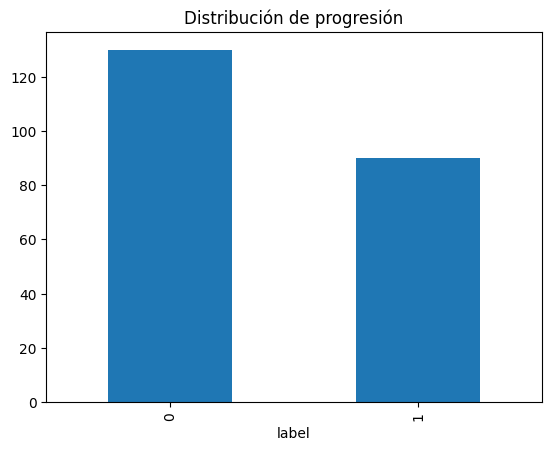

In [24]:
# [] Balance de clases
print("\n Distribución de la variable objetivo:")
display(df_tab["label"].value_counts(normalize=True).mul(100).round(2).to_frame())
df_tab["label"].value_counts().plot(kind="bar", title="Distribución de progresión")

# [Test] Z-test para comparar proporciones
counts = [df_tab["label"].value_counts()[1],
          df_tab["label"].value_counts()[0]]
nobs = [sum(counts), sum(counts)]
stat, pval = proportions_ztest(counts, nobs)
print(f"\nPrueba Z-test: Z = {stat:.2f}, p-value = {pval:.4f}")


## _Estandarización de las imágenes_

In [ ]:
# Medidas más comunes
display(out['orientation'].value_counts().to_frame())
display(out['shape'].value_counts().to_frame().head(3))
display(out['voxel_size'].value_counts().to_frame().head(3))


,count
orientation,
"(R, A, S)",192
"(P, S, R)",28


,count
shape,
"(166, 256, 256)",79
"(160, 192, 192)",77
"(180, 256, 256)",25


,count
voxel_size,
"(1.2, 0.9375, 0.9375)",97
"(1.2, 1.25, 1.25)",75
"(0.9375, 0.9375, 1.2)",27


In [35]:
import shutil

def preprocess_mri_folder(
        BASE_DIR  = Path(r"C:\Users\usuario\MRI\IMAGES_NII"),
        output_folder=r"C:\Users\usuario\MRI\IMAGES_npy",
        target_shape=(160,192,192),
        target_spacing=(1.0,1.0,1.0)
    ):
    
    if os.path.exists(output_folder):
        print("🧹 Limpiando carpeta de salida...")
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)

    # Encuentra TODOS los .nii y .nii.gz dentro de todas las carpetas
    nii_files = list(BASE_DIR.rglob("*.nii")) + list(BASE_DIR.rglob("*.nii.gz"))

    print(f"Total imágenes encontradas: {len(nii_files)}")

    for fname in tqdm(nii_files, desc="Procesando MRI", unit="img"):
        #print(f"\nProcesando: {fname}")

        # ----------------------
        # 1) Cargar imagen y orientar a RAS
        # ----------------------
        img = sitk.ReadImage(os.path.join(BASE_DIR, fname))
        img = sitk.DICOMOrient(img, "RAS")

        # ----------------------
        # 2) Resamplear a voxel 1.0 mm
        # ----------------------
        original_spacing = img.GetSpacing()
        original_size = img.GetSize()

        new_size = [
            int(round(original_size[i] * (original_spacing[i] / target_spacing[i])))
            for i in range(3)
        ]

        resampler = sitk.ResampleImageFilter()
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetOutputSpacing(target_spacing)
        resampler.SetSize(new_size)
        resampler.SetOutputDirection(img.GetDirection())
        resampler.SetOutputOrigin(img.GetOrigin())

        img_resampled = resampler.Execute(img)

        # Convertir a numpy
        arr = sitk.GetArrayFromImage(img_resampled)  # (D,H,W)

        # ----------------------
        # 3) Ajustar tamaño a (160,192,192)
        #    — Crop o pad automático
        # ----------------------
        def resize_to_shape(volume, target):
            out = np.zeros(target, dtype=volume.dtype)
            
            # cálculo de offsets
            d, h, w = volume.shape
            td, th, tw = target
            
            # límites
            d0 = max((td - d)//2, 0); d1 = d0 + min(d, td)
            h0 = max((th - h)//2, 0); h1 = h0 + min(h, th)
            w0 = max((tw - w)//2, 0); w1 = w0 + min(w, tw)
            
            vd0 = max((d - td)//2, 0); vd1 = vd0 + min(d, td)
            vh0 = max((h - th)//2, 0); vh1 = vh0 + min(h, th)
            vw0 = max((w - tw)//2, 0); vw1 = vw0 + min(w, tw)
            
            out[d0:d1, h0:h1, w0:w1] = volume[vd0:vd1, vh0:vh1, vw0:vw1]
            return out

        arr = resize_to_shape(arr, target_shape)

        # ----------------------
        # 4) Normalizar intensidad (z-score)
        # ----------------------
        arr = arr.astype(np.float32)
        m = np.mean(arr)
        s = np.std(arr) + 1e-6
        arr = (arr - m) / s

        # ----------------------
        # 5) Guardar como .npy
        # ----------------------
        
        subject_id = fname.parents[3].name
        image_id = fname.parents[0].name

        out_name = f"{subject_id}_{image_id}.npy"
        out_path = os.path.join(output_folder, out_name)
        
        np.save(out_path, arr)

        #print(f"✔ Guardado: {out_path}")

    print("\n🎉 Procesamiento completado.")


# Ejecutar
preprocess_mri_folder()


🧹 Limpiando carpeta de salida...
Total imágenes encontradas: 220


Procesando MRI: 100%|██████████| 220/220 [00:46<00:00,  4.70img/s]


🎉 Procesamiento completado.
